In [14]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt
import gym
import blackjack as bj  #NoJoke

In [410]:
env = bj.BlackjackEnv()
Verbose = False     
is_boost = True

In [443]:
# given the player's score, whether it has a usable ace, and the dealer's facing up card
# returns the Q-table index
def index(player_score, usable_ace, dealer_card, boost=False):
    if not boost:
        if player_score < 12:
            return (player_score - 4) * 10 + (dealer_card - 1)
        return 80 + (player_score - 12) * 20 + (dealer_card - 1) * 2 + usable_ace * 1
    return (player_score - 12) * 20 + (dealer_card - 1) * 2 + usable_ace * 1



# given the Q-table, the player's score, whether it has a usable ace, the dealer's facing up card and the exploration rate
# returns a random action with probability epsilon
# or the most probable one according to the current Q-table with probability 1-epsilon
def q_learning_action(Q_actions, epsilon, Q_double_actions=None):
    # epsilon-greedy exploration
    if np.random.random() < epsilon:
        return env.action_space.sample()
    
    if Q_double_actions is not None:
        return np.argmax(np.concatenate((Q_actions, Q_double_actions))) % 2
    
    # Q-Learning optimization
    return np.argmax(Q_actions) 
    
    
    
# returns a decreasing (exploration) rate, in a inverted sigmoid-like (but with a piecewise linear function) shape
def decrease_rate(x):
    # returns a high exploration rate in the first epochs
    if x < 0.05:
        return 1
    if x < 0.1:
        return 1 - 0.05 * (x - 0.05) / 0.05
    # the exploration rate is then decreasing a lot in the next few epochs
    elif x < 0.25:
        return 0.95 - 0.9 * (x - 0.1) / 0.15
    # the exploration rate decrease slower in the last epochs
    elif x < 0.3:
        return 0.05 - 0.05 * (x - 0.25) / 0.05
    # no more exploration
    return 0

### to plot the inverted sigmoid-like shape
# x = np.linspace(0,1,100)
# y = [decrease_rate(el) for el in x]
# plt.plot(x, y)
# plt.show()
    

    
    

    
def main(train=False, Q=None, Q_double=None, lr=0.115, gamma=0.15, epsilon=0.3, nb_games=100000, boost=False, double_Q_learning=False, plot_perf=False, Verbose=False):
    # stats of the agent
    avg_win = 0
    avg_tie = 0
    
    # to keep memory of every couple state/action taken in every game
    lst_states_actions_rewards = np.zeros((4, 3), dtype=int)
    
    # to keep memory of performance over training
    if plot_perf:
        perfs = []
        epochs = []
    
    
    
    if train:   
        if not boost:
            # states: 4 to 21 (all the player scores possible => 18); whether the player has a soft ace or not (only for player scores higher than 12 => 2 * 10); and dealer's first card out (1 to 10 => 10)
            # hence (8 + 10 * 2) * 10 = 280 states
            # actions: 0 (stand) or 1 (hit)
            Q = np.zeros((280, 2))
            if double_Q_learning:
                Q_double = np.zeros((280, 2))
        else:
            # states: 12 to 20 (all the non-trivial player scores possible, see below => 9); whether the player has a soft ace or not (=> 2); and dealer's first card out (1 to 10 => 10)
            # hence 9 * 2 * 10 = 180 states
            # actions: 0 (stand) or 1 (hit)
            Q = np.zeros((180, 2))
            if double_Q_learning:
                Q_double = np.zeros((180, 2))
    else:
        epsilon = 0
            
            
            
    # for-loop to run nb_games blackjack games
    for i_game in range(nb_games):
        player_hand, dealer_card, usable_ace = env.reset()
        player_score = bj.sum_hand(player_hand)
          
        #'''
        if train:
            if i_game < 3000:
                epsilon = 1
            else:
                epsilon = 0
#             epsilon = decrease_rate(i_game / nb_games)
            
            if boost and (player_score <= 11 or player_score == 21):
                lst_states_actions_rewards[0, 0] = -1               # to know whether Q index exists
            else:
                lst_states_actions_rewards[0, 0] = index(player_score, usable_ace, dealer_card, boost)
            
        #lr = 0.2 * decrease_rate(i_game / nb_games)
        #'''

        
        # according to the official rules, there cannot be more than 3 passes
        for t in range(3):
            
            # first move is random
            if i_game == 0 and t == 0:
                action = env.action_space.sample()
                
            # to help the learning of our agent with trivial actions
            if boost and (player_score <= 11 or player_score == 21):
                # we want to hit (action=1) if the player score is lower than 11 (as the player cannot bust)
                # we want to stand (action=0) if the player score is equal to 21 (as the player cannot perform better)
                action = (player_score <= 11) * 1 
                                    
            elif double_Q_learning:
                action = q_learning_action(Q[index(player_score, usable_ace, dealer_card, boost)], epsilon, Q_double_actions=Q_double[index(player_score, usable_ace, dealer_card, boost)])
            else:
                action = q_learning_action(Q[index(player_score, usable_ace, dealer_card, boost)], epsilon)
                
            
            observation, reward, done, info = env.step(action)
            new_player_hand, dealer_card, usable_ace = observation
            new_player_score = bj.sum_hand(new_player_hand)
            
            if train:
                lst_states_actions_rewards[t, 1] = action
                lst_states_actions_rewards[t, 2] = reward
                if (boost and (new_player_score <= 11 or new_player_score == 21)) or new_player_score > 21:
                    lst_states_actions_rewards[t + 1, 0] = -1               # to know whether Q index exists
                else:
                    lst_states_actions_rewards[t + 1, 0] = index(new_player_score, usable_ace, dealer_card, boost) 
              
            
                        
            
            if Verbose:
                print("Pass {} - Player's score:".format(t), player_score)
                if player_score > 21:
                    print("Player has busted.")


            if done:
                if train:
                    #'''
                    # to perform a retroactive learning (applied variation of n-step Q-learning)
                    for i_update in range(t + 1):
                        if lst_states_actions_rewards[i_update, 0] != -1:
                            
                            # computing the n-step reward
                            reward = 0
                            for i in range(i_update + 1):
                                reward *= gamma
                                reward += lst_states_actions_rewards[i, 2]
#                                 if lst_states_actions_rewards[i, 2] == 0:
#                                     reward += 0.5
#                                 elif lst_states_actions_rewards[i, 2] == 1:
#                                     reward += 1
                                

                            # Double Q-learning update
                            if double_Q_learning:
                                if np.random.random() < .5:     
                                    Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] *= 1 - lr
                                    
                                    if lst_states_actions_rewards[i_update + 1, 0] == -1:
                                        Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * reward    # that's it, as Q[lst_states_actions_rewards[i_update + 1, 0]] = 0 (lst_states_actions_rewards[i_update + 1, 0] is a final state)
                                    else:
                                        Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * (reward + np.power(gamma, i_update) * Q_double[lst_states_actions_rewards[i_update + 1, 0], np.argmax(Q[lst_states_actions_rewards[i_update + 1, 0]])])
                                
                                else:
                                    Q_double[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] *= 1 - lr
                                    
                                    if lst_states_actions_rewards[i_update + 1, 0] == -1:
                                        Q_double[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * reward    # that's it, as Q_double[lst_states_actions_rewards[i_update + 1, 0]] = 0 (lst_states_actions_rewards[i_update + 1, 0] is a final state)
                                    else:
                                        Q_double[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * (reward + np.power(gamma, i_update) * Q[lst_states_actions_rewards[i_update + 1, 0], np.argmax(Q_double[lst_states_actions_rewards[i_update + 1, 0]])])

                            # Q-learning update
                            else:
                                Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] *= 1 - lr
                                #Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * reward
                                    
                                if lst_states_actions_rewards[i_update + 1, 0] == -1:
                                    Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * reward    # that's it, as Q[lst_states_actions_rewards[i_update + 1, 0]] = 0 (lst_states_actions_rewards[i_update + 1, 0] is a final state)
                                else:
                                    Q[lst_states_actions_rewards[i_update, 0], lst_states_actions_rewards[i_update, 1]] += lr * (reward + np.power(gamma, i_update) * np.max(Q[lst_states_actions_rewards[i_update + 1, 0]]))

                    #'''
                    ''''''        
                    epsilon *= 0.999
                    lr *= 0.999
                    ''''''
                    
                                    
                                    
                if Verbose:
                    dealer_score = bj.score(env.dealer)
                    print("Dealer's score:", dealer_score)
                    if dealer_score > 21:
                        print("Dealer has busted.")
                
                #if the player won the game
                if reward == 1.:
                    avg_win += 1
                    if Verbose:
                        print("GAME WON")
                        print()
                #if there has been a draw
                elif reward == 0:
                    avg_tie += 1
                    if Verbose:
                        print("TIE")
                        print()
                #if the player lost the game
                else:
                    if Verbose:
                        print("GAME LOST")
                        print()
                break
                
                                   
            player_score = new_player_score
            
            
            
        if plot_perf and i_game > 0 and i_game % 100 == 0:
            perfs.append(100 * ((2 * avg_win + avg_tie) / i_game - 1))
            epochs.append(i_game)
                        
            
            
        
    if plot_perf:
        plt.plot(epochs, perfs)
        plt.show()
        
    if Verbose:
        print("Average winning score with Q-learning:", 100 * avg_win / nb_games, "%")
        print("Ties:", 100 * avg_tie / nb_games, "%  ||  Losses:", 100 * (1 - (avg_win + avg_tie) / nb_games), "%")
        print("Performance over 100 games:", round(100 * ((2 * avg_win + avg_tie) / nb_games - 1), 2))

    env.close()

    print(avg_win/nb_games)
    print(avg_tie/nb_games)
    
    #if in train mode, return the Q-table (and the Q_double table)
    if train:
        print(round(100 * ((2 * avg_win + avg_tie) / nb_games - 1), 2))
        if double_Q_learning:
            return Q, Q_double
        return Q
    
    #if not in train mode, return the performance over 100 games
    return round(100 * ((2 * avg_win + avg_tie) / nb_games - 1), 2)

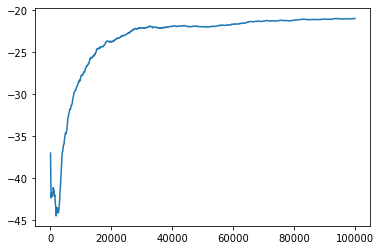

0.33838
0.11351
-20.97


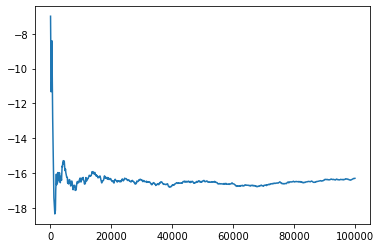

0.37601
0.08498
-16.3


In [450]:
Q_table = main(train=True, boost=False, nb_games=100000, epsilon=0.3, gamma=0.15, lr=0.115, plot_perf=True)
print(main(train=False, Q=Q_table, boost=False, nb_games=100000, plot_perf=True))

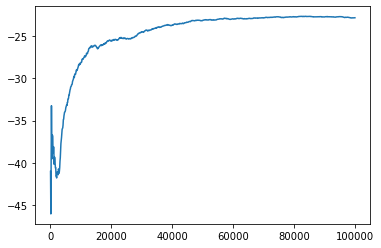

0.32826
0.11475
-22.87


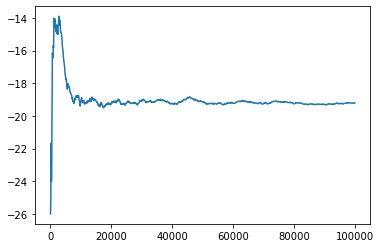

0.3623
0.0832
-19.22


In [460]:
Q_table, Q_double_table = main(train=True, boost=True, double_Q_learning=True, gamma=0.6, lr=0.4, plot_perf=True)
print(main(train=False, Q=Q_table, Q_double=Q_double_table, boost=True, double_Q_learning=True, plot_perf=True))

Testing different learning rates

-24.5
-18.43
-20.38
-18.15
-16.92
-18.82
-16.99
-17.76
-17.31
-19.97


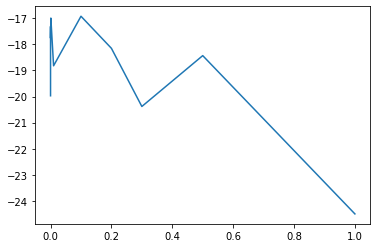

In [278]:
lst_lr = [1, 0.5, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-5, 1e-10, 0]
lst = []

for lr in lst_lr:
    Q_table = main(train=True, boost=is_boost, nb_games=50000, lr=lr)
    lst.append(main(train=False, boost=is_boost, nb_games=10000, Q=Q_table, lr=lr))
    print(lst[-1])
    
    
plt.plot(lst_lr, lst)
plt.show()

Testing different discount rates

-19.04
-16.05
-17.61
-16.7
-15.21
-17.13
-17.4
-18.1
-18.15
-17.92


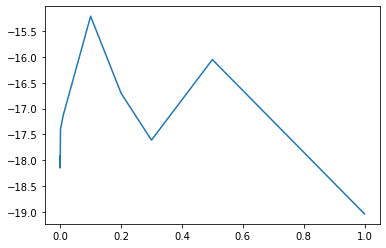

In [304]:
lst_gamma = [1, 0.5, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-5, 1e-10, 0]
lst = []

for gamma in lst_gamma:
    Q_table = main(train=True, boost=is_boost, nb_games=50000, gamma=gamma)
    lst.append(main(train=False, boost=is_boost, nb_games=10000, Q=Q_table, gamma=gamma))
    print(lst[-1])
    
    
plt.plot(lst_gamma, lst)
plt.show()

Testing different exploration rates

-17.3
-15.55
-15.99
-16.76
-18.26
-16.69
-17.04
-18.95
-17.81
-16.49


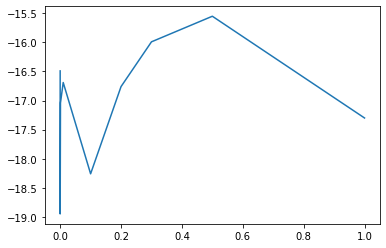

In [305]:
lst_epsilon = [1, 0.5, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-5, 1e-10, 0]
lst = []

for epsilon in lst_epsilon:
    Q_table = main(train=True, boost=is_boost, nb_games=50000, epsilon=epsilon)
    lst.append(main(train=False, boost=is_boost, nb_games=10000, Q=Q_table, epsilon=epsilon))
    print(lst[-1])
    
    
plt.plot(lst_epsilon, lst)
plt.show()

Testing best?

In [282]:
lst = [1, 0.5, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-5, 1e-10, 0]

results = np.zeros((10, 10, 10))

for i, lr in enumerate(lst):
    for j, gamma in enumerate(lst):
        for k, epsilon in enumerate(lst):
            Q_table = main(train=True, boost=is_boost, nb_games=50000, lr=lr, gamma=gamma, epsilon=epsilon)
            result = main(train=False, boost=is_boost, Q=Q_table, nb_games=10000, lr=lr, gamma=gamma, epsilon=epsilon)
            results[i, j, k] = result
            print("lr = " + str(lr) + " || gamma = " + str(gamma) + " || epsilon = " + str(epsilon))
            print(result)
    
    
plt.plot(lst, results)
plt.show()

lr = 1 || gamma = 1 || epsilon = 1
-21.0
lr = 1 || gamma = 1 || epsilon = 0.5
-22.76
lr = 1 || gamma = 1 || epsilon = 0.3
-23.04
lr = 1 || gamma = 1 || epsilon = 0.2
-19.2
lr = 1 || gamma = 1 || epsilon = 0.1
-21.42
lr = 1 || gamma = 1 || epsilon = 0.01
-24.5
lr = 1 || gamma = 1 || epsilon = 0.001
-22.9
lr = 1 || gamma = 1 || epsilon = 1e-05
-25.68
lr = 1 || gamma = 1 || epsilon = 1e-10
-22.83
lr = 1 || gamma = 1 || epsilon = 0
-23.62
lr = 1 || gamma = 0.5 || epsilon = 1
-21.63
lr = 1 || gamma = 0.5 || epsilon = 0.5
-20.64
lr = 1 || gamma = 0.5 || epsilon = 0.3
-20.41
lr = 1 || gamma = 0.5 || epsilon = 0.2
-19.78
lr = 1 || gamma = 0.5 || epsilon = 0.1
-20.5
lr = 1 || gamma = 0.5 || epsilon = 0.01
-16.78
lr = 1 || gamma = 0.5 || epsilon = 0.001
-20.87
lr = 1 || gamma = 0.5 || epsilon = 1e-05
-22.2
lr = 1 || gamma = 0.5 || epsilon = 1e-10
-20.63
lr = 1 || gamma = 0.5 || epsilon = 0
-18.88
lr = 1 || gamma = 0.3 || epsilon = 1
-18.4
lr = 1 || gamma = 0.3 || epsilon = 0.5
-19.23
lr = 1 || g

KeyboardInterrupt: 

# To print the Q-table

In [453]:
cards = [i for i in range (2, 11)]
cards.append(1)

dealer_cards = [str(i) + "" for i in cards]
dealer_cards[-2] += " or any face"
dealer_cards[-1] = "ace"
player_scores = [str(i) for i in range(4, 22)]
player_scores_with_soft_ace = [str(i) for i in range(12, 22)]


combinations_hard_ace = []
combinations_soft_ace = []
for player_score in range(4, 22):
    lst_hard_ace = []
    if player_score > 11:
        lst_soft_ace = []
    if is_boost and player_score <= 11:
        for dealer_card in cards:
            lst_hard_ace.append("HIT")
    elif is_boost and player_score == 21:
        for dealer_card in cards:
            lst_hard_ace.append("STAND")
            lst_soft_ace.append("STAND")
    else:   
        for dealer_card in cards:
            if np.argmax(Q_table[index(player_score, False, dealer_card, is_boost)]) == 0:
                lst_hard_ace.append("STAND")
            else:
                lst_hard_ace.append("HIT")
            
            if player_score > 11:
                if np.argmax(Q_table[index(player_score, True, dealer_card, is_boost)]) == 0:
                    lst_soft_ace.append("STAND")
                else:
                    lst_soft_ace.append("HIT")
    combinations_hard_ace.append(lst_hard_ace)
    if player_score > 11:
        combinations_soft_ace.append(lst_soft_ace)

        
print("With a hard ace")
print(DataFrame(np.array(combinations_hard_ace), player_scores, dealer_cards)) 
print("With a soft ace")
print(DataFrame(np.array(combinations_soft_ace), player_scores_with_soft_ace, dealer_cards))  #begins at 12

IndexError: index 182 is out of bounds for axis 0 with size 180

In [461]:
combinations_hard_ace = []
combinations_soft_ace = []

for player_score in range(4, 22):
    lst_hard_ace = []
    if player_score > 11:
        lst_soft_ace = []
    if is_boost and player_score <= 11:
        for dealer_card in cards:
            lst_hard_ace.append("HIT")
    elif is_boost and player_score == 21:
        for dealer_card in cards:
            lst_hard_ace.append("STAND")
            lst_soft_ace.append("STAND")
    else:   
        for dealer_card in cards:
            if np.argmax(np.concatenate((Q_table[index(player_score, False, dealer_card, True)], Q_double_table[index(player_score, False, dealer_card, True)]))) % 2 == 0:
                lst_hard_ace.append("STAND")
            else:
                lst_hard_ace.append("HIT")
            
            if player_score > 11:
                if np.argmax(np.concatenate((Q_table[index(player_score, True, dealer_card, True)], Q_double_table[index(player_score, True, dealer_card, True)]))) % 2 == 0:
                    lst_soft_ace.append("STAND")
                else:
                    lst_soft_ace.append("HIT")
    combinations_hard_ace.append(lst_hard_ace)
    if player_score > 11:
        combinations_soft_ace.append(lst_soft_ace)

        
print("With a hard ace")
print(DataFrame(np.array(combinations_hard_ace), player_scores, dealer_cards)) 
print("With a soft ace")
print(DataFrame(np.array(combinations_soft_ace), player_scores_with_soft_ace, dealer_cards))  #begins at 12

IndexError: index 182 is out of bounds for axis 0 with size 180

# To print Normal Play Strategy score

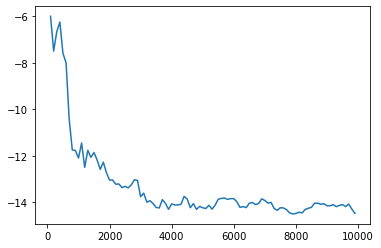

0.377
0.0992
-14.68


In [404]:
#Building Normal Play Q-table
Q_normal_play = np.zeros((280, 2))

for player_score in range(4, 22):
    for dealer_card in range(1, 11):
        if player_score <= 11:
            Q_normal_play[index(player_score, False, dealer_card)] = [0, 1]
        elif player_score == 12:
            Q_normal_play[index(player_score, True, dealer_card)] = [0, 1]
            if 4 <= dealer_card <= 6:
                Q_normal_play[index(player_score, False, dealer_card)] = [1, 0]
            else:
                Q_normal_play[index(player_score, False, dealer_card)] = [0, 1]
        elif player_score <= 16:
            Q_normal_play[index(player_score, True, dealer_card)] = [0, 1]
            if 2 <= dealer_card <= 6:
                Q_normal_play[index(player_score, False, dealer_card)] = [1, 0]
            else:
                Q_normal_play[index(player_score, False, dealer_card)] = [0, 1]
        elif player_score == 17:
            Q_normal_play[index(player_score, False, dealer_card)] = [1, 0]
            Q_normal_play[index(player_score, True, dealer_card)] = [0, 1]
        elif player_score == 18:
            Q_normal_play[index(player_score, False, dealer_card)] = [1, 0]
            if 2 <= dealer_card <= 8:
                Q_normal_play[index(player_score, True, dealer_card)] = [1, 0]
            else:
                Q_normal_play[index(player_score, True, dealer_card)] = [0, 1]
        else:
            Q_normal_play[index(player_score, False, dealer_card)] = [1, 0]
            Q_normal_play[index(player_score, True, dealer_card)] = [1, 0]
            


            
print(main(train=False, Q=Q_normal_play, boost=False, nb_games=10000, plot_perf=True))

To print Normal Play strategy

In [38]:
combinations_normal_play_hard_ace = []
combinations_normal_play_soft_ace = []

for player_score in range(4, 22):
    lst_hard_ace = []
    if player_score > 11:
        lst_soft_ace = []
      
    for dealer_card in cards:
        if np.argmax(Q_normal_play[index(player_score, False, dealer_card)]) == 0:
            lst_hard_ace.append("STAND")
        else:
            lst_hard_ace.append("HIT")

        if player_score > 11:
            if np.argmax(Q_normal_play[index(player_score, True, dealer_card)]) == 0:
                lst_soft_ace.append("STAND")
            else:
                lst_soft_ace.append("HIT")
    combinations_normal_play_hard_ace.append(lst_hard_ace)
    if player_score > 11:
        combinations_normal_play_soft_ace.append(lst_soft_ace)

        
print("With a hard ace")
print(DataFrame(np.array(combinations_normal_play_hard_ace), player_scores, dealer_cards)) 
print("With a soft ace")
print(DataFrame(np.array(combinations_normal_play_soft_ace), player_scores_with_soft_ace, dealer_cards))  #begins at 12

With a hard ace
        2      3      4      5      6      7      8      9 10 or any face  \
4     HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
5     HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
6     HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
7     HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
8     HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
9     HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
10    HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
11    HIT    HIT    HIT    HIT    HIT    HIT    HIT    HIT            HIT   
12    HIT    HIT  STAND  STAND  STAND    HIT    HIT    HIT            HIT   
13  STAND  STAND  STAND  STAND  STAND    HIT    HIT    HIT            HIT   
14  STAND  STAND  STAND  STAND  STAND    HIT    HIT    HIT            HIT   
15  STAND  STAND  STAND  STAND  STAND    HIT    HIT    HIT  

In [448]:
err = 0

if is_boost:
    for i in range(180):
        if np.argmax(Q_table[i]) != np.argmax(Q_normal_play[i + 80]):
            err += 1
    err /= 1.8
else:
    for i in range(280):
        if np.argmax(Q_table[i]) != np.argmax(Q_normal_play[i]):
            err += 1
    err /= 2.8
    
print(str(err) + "%")

28.214285714285715%


For Double Q-Learning:

In [447]:
err = 0

if is_boost:
    for i in range(180):
        if np.argmax(np.concatenate((Q_table[i], Q_double_table[i]))) % 2 != np.argmax(Q_normal_play[i + 80]):
            err += 1
    err /= 1.8
else:
    for i in range(280):
        if np.argmax(np.concatenate((Q_table[i], Q_double_table[i]))) % 2 != np.argmax(Q_normal_play[i]):
            err += 1
    err /= 2.8
    
print(str(err) + "%")

29.642857142857146%
